
#### Latent Consistency Model (LCM) enable fast high-quality image generation  by directly predicting the reverse diffusion process in the latent rather than pixel space.
#### LCMs try to predict the noiseless image from the noisy image in contrast to typical diffusion models that iteratively remove noise from the noisy image.

In [1]:
! pip install -q "diffusers==0.30.3" "transformers==4.44.2" "peft==0.12.0"

In [2]:
from diffusers import StableDiffusionXLPipeline, UNet2DConditionModel, LCMScheduler, AutoPipelineForImage2Image
import torch
from diffusers.utils import load_image, make_image_grid

# Text-to-image

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.83k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 17 files:   0%|          | 0/17 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

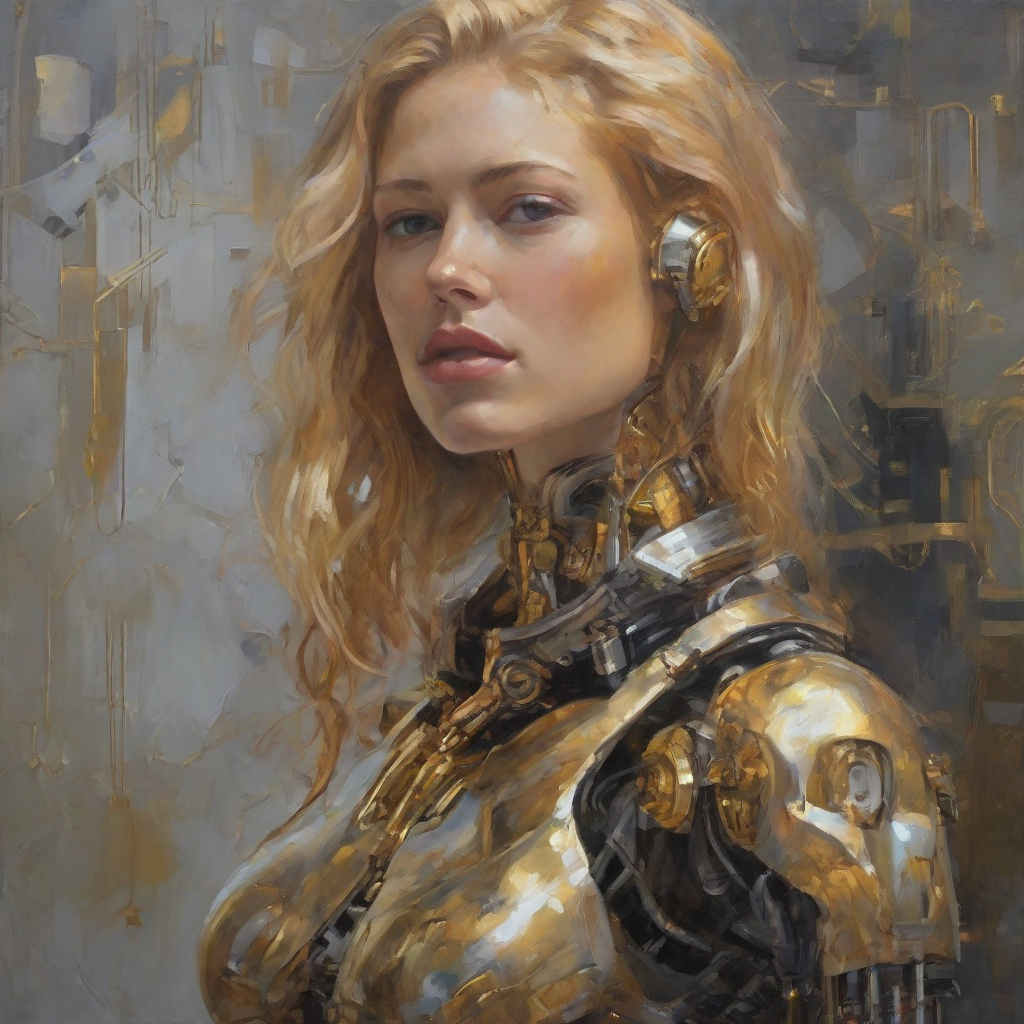

In [3]:
unet = UNet2DConditionModel.from_pretrained(
    "latent-consistency/lcm-sdxl",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16, variant="fp16",
).to("cuda")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"
generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt, num_inference_steps=4, generator=generator, guidance_scale=8.0
).images[0]
image

# Image-to-image

In [ ]:
unet = UNet2DConditionModel.from_pretrained(
    "SimianLuo/LCM_Dreamshaper_v7",
    subfolder="unet",
    torch_dtype=torch.float16,
)

pipe = AutoPipelineForImage2Image.from_pretrained(
    "Lykon/dreamshaper-7",
    unet=unet,
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

##### Adjust the values for num_inference_steps, strength, and guidance_scale to get the best results.

  0%|          | 0/8 [00:00<?, ?it/s]

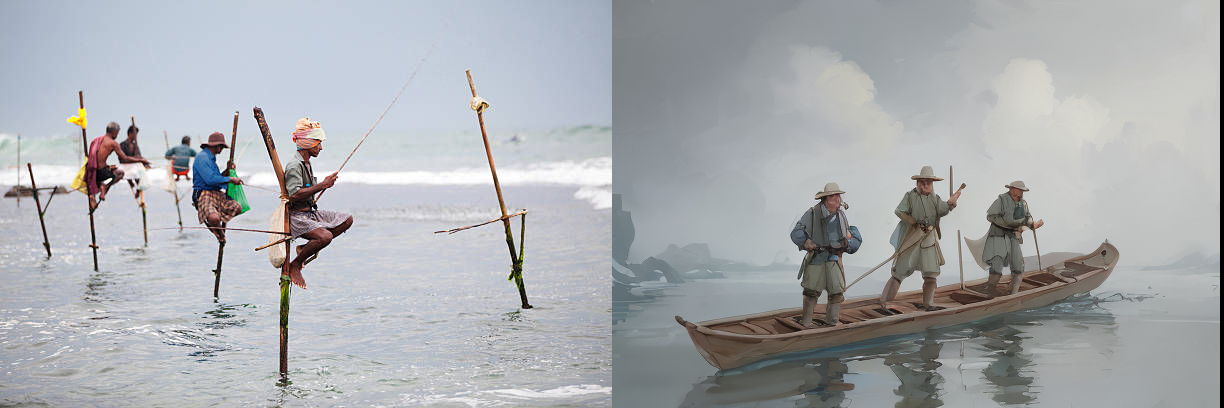

In [10]:
init_image = load_image("/content/fishermen.jpg")
prompt = "Fisher men in a river, cold color palette, muted colors, detailed, 8k"
generator = torch.manual_seed(0)
image = pipe(
    prompt,
    image=init_image,
    num_inference_steps=10,
    guidance_scale=7.5,
    strength=0.8,
    generator=generator
).images[0]
image
make_image_grid([init_image, image], rows=1, cols=2)

# Adapter - LoRA

LCMs are compatible with adapters like LoRA, ControlNet, T2I-Adapter, and AnimateDiff.

In [3]:
unet = UNet2DConditionModel.from_pretrained(
    "latent-consistency/lcm-sdxl",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", unet=unet, torch_dtype=torch.float16, variant="fp16",
).to("cuda")

pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)

pipe.load_lora_weights("TheLastBen/Papercut_SDXL", weight_name="papercut.safetensors", adapter_name="papercut")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


papercut.safetensors:   0%|          | 0.00/341M [00:00<?, ?B/s]

  0%|          | 0/4 [00:00<?, ?it/s]

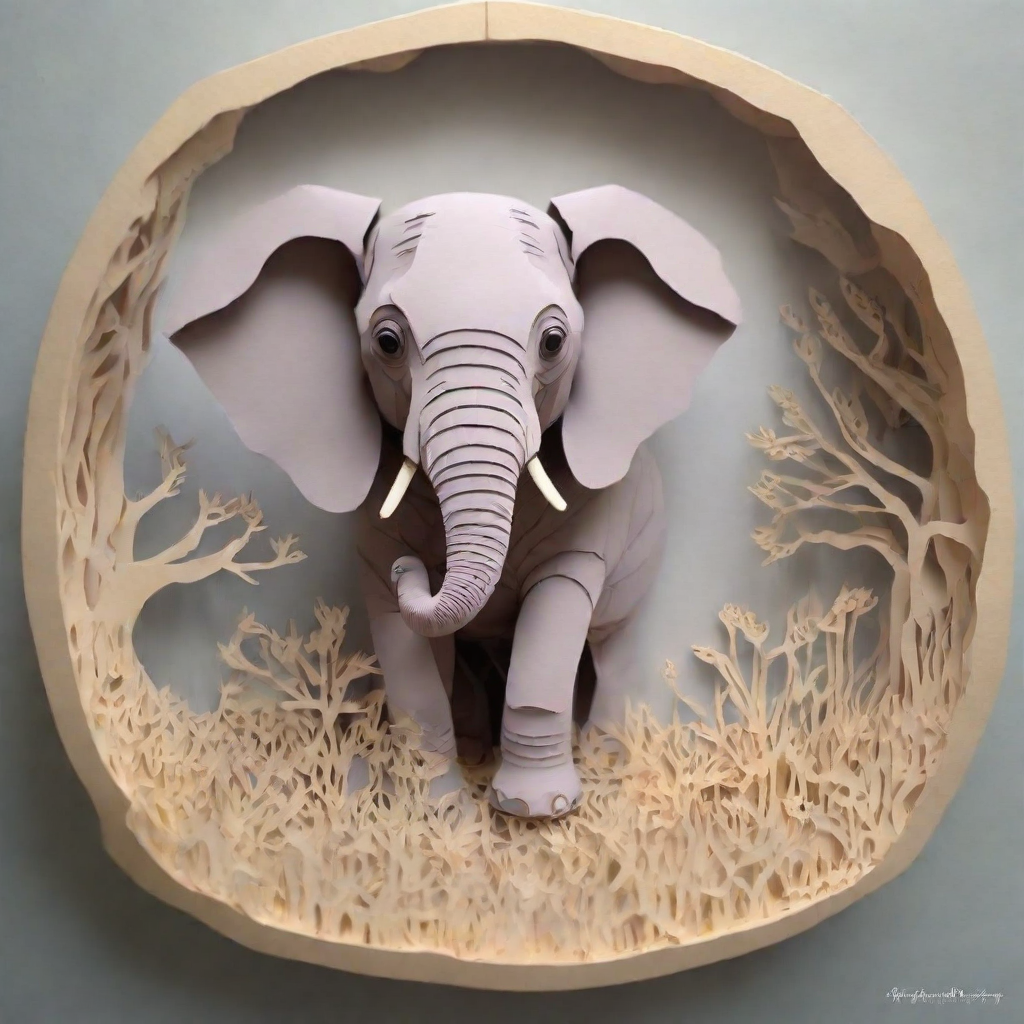

In [4]:
prompt = "papercut, a cute elephant"
generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt, num_inference_steps=4, generator=generator, guidance_scale=8.0
).images[0]
image

  0%|          | 0/4 [00:00<?, ?it/s]

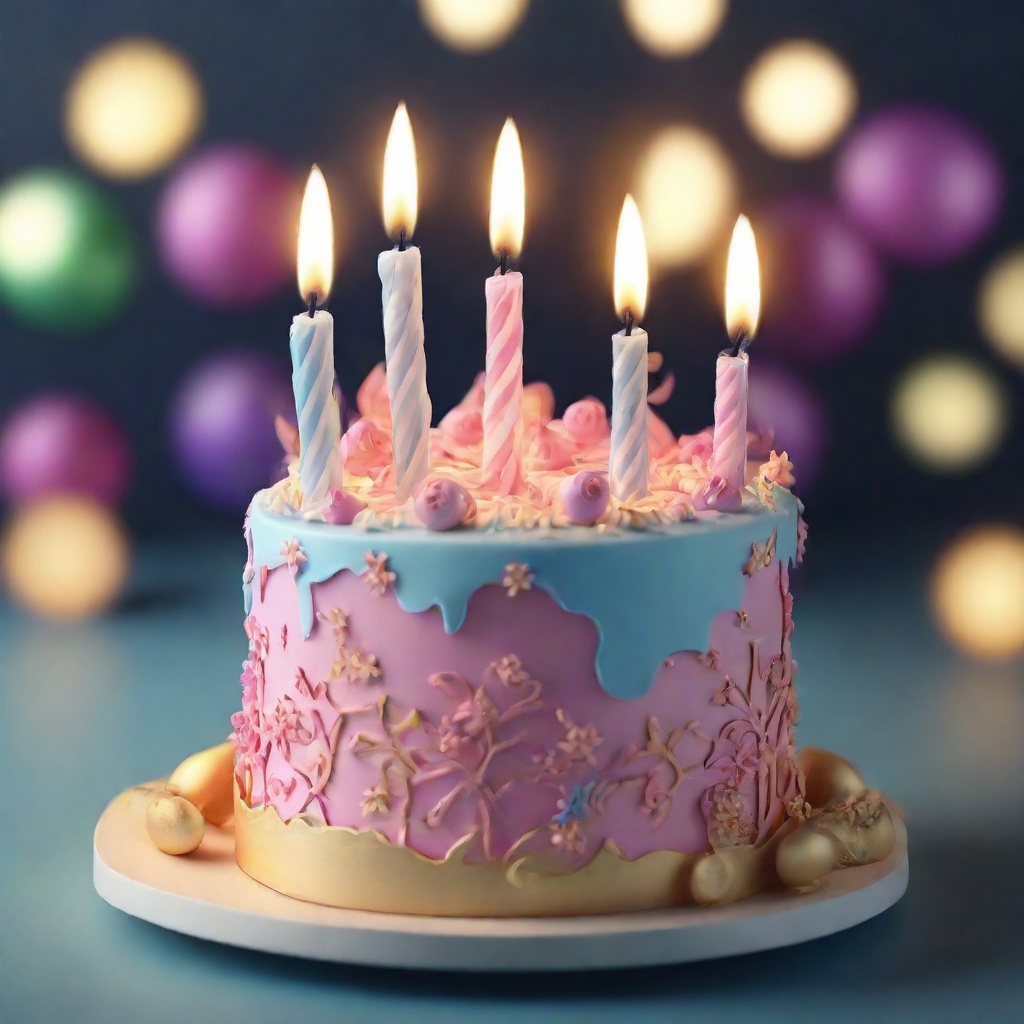

In [5]:
prompt = "A beautiful birthday cake with candles and decorations in a photorealistic style, detailed lighting"
generator = torch.manual_seed(0)
image = pipe(
    prompt=prompt, num_inference_steps=4, generator=generator, guidance_scale=8.0
).images[0]
image

##### Using LoRA (Low-Rank Adaptation) weights in a text-to-image generation task (e.g., with Stable Diffusion), you can integrate LoRA weights into your existing diffusion model pipeline.

##### The **load_lora_weights** function is used to load LoRA weights (**papercut.safetensors**) into the model pipeline.